In [1]:
# Importing necessary packages TEST test
from datetime import date, timedelta
import os
import requests
import shutil
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tqdm
import logging

In [3]:
# Set start date and end date, with 7 days interval
start = date(2020, 1, 3)
end = date.today()
week = timedelta(days=7)

# Creating a list with dates from start to end and 7-days interval
dates_string = []
mydate = start
while mydate < end:
    dates_string.append("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate))
    mydate += week

In [4]:
URL_job = []
# Creating a list with URL's for each week top 200 charts
for i, j in zip(dates_string[0:-1], dates_string[1:]):
    URL_job.append(f'https://spotifycharts.com/regional/dk/weekly/{i}--{j}/download')

In [7]:
# Finds current directory and makes a new folder 'Spotify_files' and changes directory to 'Spotify_files'
path = os.getcwd()
os.mkdir(f'{path}/Spotify_files')
os.chdir(f'{path}/Spotify_files')

#Logs requests
logging.basicConfig(filename = 'log1.txt',level=logging.DEBUG)

# Downloads every weeks top 200 charts as csv file and place them in the folder 'Spotify_files'.
for i in URL_job:
    r = requests.get(i, verify=True,stream=True)
    if r.status_code!=200:
        print( "Failure")
        exit()
    else:
        r.raw.decode_content = True
        with open(f'{i[45:67]}.csv', 'wb',) as f:
            shutil.copyfileobj(r.raw, f)
        print("Success")

# Changes directory back to original path
os.chdir(path)

'\n#Logs requests\nlogging.basicConfig(filename = \'log1.txt\',level=logging.DEBUG)\n\n# Downloads every weeks top 200 charts as csv file and place them in the folder \'Spotify_files\'.\nfor i in URL_job:\n    r = requests.get(i, verify=True,stream=True)\n    if r.status_code!=200:\n        print( "Failure")\n        exit()\n    else:\n        r.raw.decode_content = True\n        with open(f\'{i[45:67]}.csv\', \'wb\',) as f:\n            shutil.copyfileobj(r.raw, f)\n        print("Success")\n\n# Changes directory back to original path\nos.chdir(path)'

In [14]:
dataframes = []
# Makes a list of the downloaded csv files
for i in URL_job:
    df = pd.read_csv(f'{path}/Spotify_files/{i[45:67]}.csv', header=1)
    df['date'] = i[45:67]
    dataframes.append(df)

# Concatenates all the csv files into a dataframe
combined_csv = pd.concat(dataframes).reset_index(drop=True)

# Slices dates such that they only consist of the first date of the the week
combined_csv['date'] = combined_csv['date'].str.slice(0,10)

# Changes format to datetime
combined_csv['date'] = pd.to_datetime(combined_csv['date'])

# Makes a new variable 'uri', slightly different from URL
combined_csv['uri'] = 'spotify:track:' + combined_csv['URL'].str.slice(31,53)

In [15]:
combined_csv

,Position,Track Name,Artist,Streams,URL,date,uri
0,1,PUB G (feat. Branco & Larry 44),LOLO,613471,https://open.spotify.com/track/0alp0O9d7KTtAF1...,2020-01-03,spotify:track:0alp0O9d7KTtAF1QnBqqiv
1,2,Yummy,Justin Bieber,498327,https://open.spotify.com/track/41L3O37CECZt3N7...,2020-01-03,spotify:track:41L3O37CECZt3N7ziG2z7l
2,3,Blinding Lights,The Weeknd,441317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,2020-01-03,spotify:track:0sf12qNH5qcw8qpgymFOqD
3,4,Kærlighed (feat. Gilli & Kesi),ATYPISK,428895,https://open.spotify.com/track/2xeiAqqHWYXQMWk...,2020-01-03,spotify:track:2xeiAqqHWYXQMWk6s2aQdw
4,5,Dance Monkey,Tones And I,401189,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,2020-01-03,spotify:track:1rgnBhdG2JDFTbYkYRZAku
...,...,...,...,...,...,...,...
195,196,WHAT TO DO? (feat. Don Toliver),JACKBOYS,59495,https://open.spotify.com/track/4AO1XhrgJczQ9bN...,2020-01-03,spotify:track:4AO1XhrgJczQ9bNVxdfKQe
196,197,Complicated - Faustix Remix,Alexander Oscar,59415,https://open.spotify.com/track/0HbPfCPmndvkevg...,2020-01-03,spotify:track:0HbPfCPmndvkevg4TjwcJQ
197,198,The London (feat. J. Cole & Travis Scott),Young Thug,59377,https://open.spotify.com/track/3s4mrPrEFFPF0Lm...,2020-01-03,spotify:track:3s4mrPrEFFPF0LmAfutW0n
198,199,Lyca (feat. Kesi),Gilli,59299,https://open.spotify.com/track/3TD0VtH37WAjrGf...,2020-01-03,spotify:track:3TD0VtH37WAjrGflIzeS0H


In [7]:
# Passes client id and client secret to spotipy
cid = 'e3da1cac4264428cbe476f7d055db765'
secret = 'b87a66e1c3a948d295549023b963f2cb'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [8]:
def get_track_features(id):
    '''Takes an uri, URL or track id and returns a list of lists with some metadata
    and its musical features''' 
    meta = sp.track(id)
    features = sp.audio_features(id)
    
    # Metadata
    name = meta['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    
    # Musical features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    valence = features[0]['valence']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    URL = features[0]['uri']
    track = [name, release_date ,length, danceability, acousticness, energy, instrumentalness,     liveness, loudness, speechiness, valence, tempo, time_signature, URL]
    return track

# Running get_track_features function on all tracks
tracks_features = []
for i in tqdm.tqdm(combined_csv['URL']):
    tracks_features.append(get_track_features(i))

  2%|▏         | 102/6400 [00:15<09:45, 10.76it/s]

KeyboardInterrupt: 

In [25]:
# Converts list of all track features to a dataframe
df = pd.DataFrame(tracks_features, columns = ['name','release_date', 'length', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence','tempo', 'time_signature','uri'])

# Merges dataframe with weekly top 200 charts with dataframe containing all track features. 
# Merge is made on index since the order of the dataframes are similar
combined_csv_joined = pd.merge(combined_csv, df, left_index=True, right_index=True)\
                        .drop('name', axis=1)\
                        .to_csv('songs_and_audio_features.csv')


NameError: name 'tracks_features' is not defined

In [38]:
# Importing csv file
df = pd.read_csv('songs_and_audio_features.csv')\
       .drop(['URL','uri_y','Unnamed: 0'], axis=1)\
       .rename(columns={'uri_x': 'URI'})
# Creating empty list for dataframes and a list to distinguish between different top charts
list_of_dfs = []
top_lists = [10,50,100,200]
# Creating four dataframes for, one each top chart
for i in top_lists:   
    list_of_dfs.append((df.loc[df['Position'] <= i])\
               .reset_index()\
               .drop('index', axis=1))

,Position,Track Name,Artist,Streams,date,URI,release_date,length,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,weeks_in_top
0,1,PUB G (feat. Branco & Larry 44),LOLO,613471,2020-01-03,spotify:track:0alp0O9d7KTtAF1QnBqqiv,2019-12-20,159722,0.822,0.31800,0.586,0.000000,0.1130,-6.834,0.1120,0.297,118.002,4,11
1,2,Yummy,Justin Bieber,498327,2020-01-03,spotify:track:41L3O37CECZt3N7ziG2z7l,2020-01-03,210426,0.687,0.36600,0.514,0.000000,0.1160,-6.612,0.0897,0.494,145.921,4,2
2,3,Blinding Lights,The Weeknd,441317,2020-01-03,spotify:track:0sf12qNH5qcw8qpgymFOqD,2019-11-29,201573,0.513,0.00147,0.796,0.000209,0.0938,-4.075,0.0629,0.345,171.017,4,11
3,4,Kærlighed (feat. Gilli & Kesi),ATYPISK,428895,2020-01-03,spotify:track:2xeiAqqHWYXQMWk6s2aQdw,2019-11-14,173182,0.903,0.01300,0.686,0.000000,0.0484,-5.065,0.1140,0.686,114.980,4,5
4,5,Dance Monkey,Tones And I,401189,2020-01-03,spotify:track:1rgnBhdG2JDFTbYkYRZAku,2019-05-10,209754,0.825,0.68800,0.593,0.000161,0.1700,-6.401,0.0988,0.540,98.078,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,Blå Himmel (feat. Hans Philip),KESI,779645,2020-07-31,spotify:track:0qA2qykpcGdVl3tiiYum4g,2020-07-31,228590,0.743,0.20000,0.529,0.000000,0.2440,-5.292,0.1070,0.505,102.027,4,2
68,5,Hygger Mig pt. 2 (feat. Gilli),KESI,466459,2020-07-31,spotify:track:0XS0OGv7EeH6cj0zCKZnkw,2020-07-31,176318,0.692,0.21900,0.591,0.000000,0.6720,-6.964,0.2610,0.822,103.792,4,2
69,7,Tilbage,KESI,460314,2020-07-31,spotify:track:5ktsLwoQZ7JVliJMjEfBZj,2020-07-31,180834,0.761,0.10800,0.672,0.000000,0.3260,-5.180,0.1150,0.781,96.990,4,2
70,9,Baku (feat. ICEKIID),KESI,377462,2020-07-31,spotify:track:22uhcnBpHHimYci7vnj7KC,2020-07-31,220175,0.696,0.06520,0.815,0.000004,0.0761,-6.966,0.1310,0.710,106.018,4,1


In [41]:
#Creates a list of the musical features
musical_variables =  ["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]
#Creates a new dataframe with only musical features
df_musical = df[["date", "danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]
df_musical

,date,danceability,acousticness,energy,instrumentalness,liveness,speechiness,valence
0,2020-01-03,0.822,0.31800,0.586,0.000000,0.1130,0.1120,0.297
1,2020-01-03,0.687,0.36600,0.514,0.000000,0.1160,0.0897,0.494
2,2020-01-03,0.513,0.00147,0.796,0.000209,0.0938,0.0629,0.345
3,2020-01-03,0.903,0.01300,0.686,0.000000,0.0484,0.1140,0.686
4,2020-01-03,0.825,0.68800,0.593,0.000161,0.1700,0.0988,0.540
...,...,...,...,...,...,...,...,...
6395,2020-08-07,0.656,0.20100,0.890,0.000002,0.1010,0.1870,0.268
6396,2020-08-07,0.934,0.00719,0.530,0.000000,0.1100,0.2170,0.432
6397,2020-08-07,0.842,0.25200,0.664,0.000000,0.1000,0.0647,0.531
6398,2020-08-07,0.677,0.04040,0.744,0.000160,0.0740,0.0295,0.631


In [32]:
# Creating empty lists and list of indexs
list_of_temps = []
final_list =[]
list_of_idexs = [0,1,2,3]
# Counting how many weeks each has been on the respective top chart
for i in list_of_dfs:    
    i['weeks_in_top'] = pd.Series(np.random.randn(len(i)))
    temp = i.groupby('URI')['weeks_in_top'].count()
    list_of_temps.append(temp)
# Merging list which counts each song and dropping duplicates
for i, j in zip(list_of_dfs,list_of_temps):
    final_list.append(pd.merge(i, j,on ='URI',how ='inner')\
              .drop('weeks_in_top_x', axis=1)\
              .rename(columns={'weeks_in_top_y': 'weeks_in_top'})\
              .drop_duplicates('URI')\
              .reset_index()\
              .drop('index', axis=1))
# Creating final dataframes
for i, j in zip(top_lists,list_of_idexs):
    exec(f'df_top{i} = final_list[j]')


In [43]:
'''for i in list_of_dfs:
    f'\{i}_split' = i[["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]'''     


df10_split = df_top10[["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]
df50_split = df_top50[["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]
df100_split = df_top100[["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]
df200_split = df[["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]       
df10_split             

,danceability,acousticness,energy,instrumentalness,liveness,speechiness,valence
0,0.822,0.31800,0.586,0.000000,0.1130,0.1120,0.297
1,0.687,0.36600,0.514,0.000000,0.1160,0.0897,0.494
2,0.513,0.00147,0.796,0.000209,0.0938,0.0629,0.345
3,0.903,0.01300,0.686,0.000000,0.0484,0.1140,0.686
4,0.825,0.68800,0.593,0.000161,0.1700,0.0988,0.540
...,...,...,...,...,...,...,...
67,0.743,0.20000,0.529,0.000000,0.2440,0.1070,0.505
68,0.692,0.21900,0.591,0.000000,0.6720,0.2610,0.822
69,0.761,0.10800,0.672,0.000000,0.3260,0.1150,0.781
70,0.696,0.06520,0.815,0.000004,0.0761,0.1310,0.710


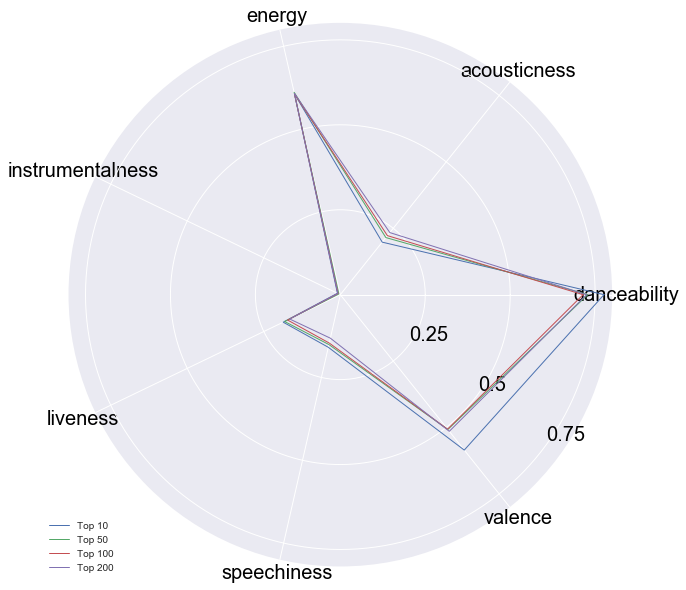

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
plt.style.use("seaborn")
 
# number of variable
categories=musical_variables
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=20)

# Draw ylabels
ax.set_rlabel_position(324)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="black", size=20)
plt.ylim(0,0.80)
 
# Plot data
#ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
#ax.fill(angles, values, 'b', alpha=0.1)

values=df10_split.mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Top 10")
#ax.fill(angles, values, 'b', alpha=0.1)
 
values=df50_split.mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Top 50")
#ax.fill(angles, values, 'r', alpha=0.1)

values=df100_split.mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Top 100")
#ax.fill(angles, values, 'r', alpha=0.1)

values=df200_split.mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Top 200")
#ax.fill(angles, values, 'r', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1,0.1))

In [17]:
!pip install git+https://github.com/johnwmillr/LyricsGenius.git

  Cloning https://github.com/johnwmillr/LyricsGenius.git to /private/var/folders/hf/dst8yh0x1_g7wzqv5f7gn7mw0000gn/T/pip-req-build-wjf9tlf2
  Running command git clone -q https://github.com/johnwmillr/LyricsGenius.git /private/var/folders/hf/dst8yh0x1_g7wzqv5f7gn7mw0000gn/T/pip-req-build-wjf9tlf2
     |████████████████████████████████| 86 kB 1.8 MB/s 
  Created wheel for lyricsgenius: filename=lyricsgenius-1.8.10-py3-none-any.whl size=15398 sha256=38fc59f3f3196d967ace5bc0c3c1f57182c2e7264ea8f3066edd5976da9944a1
  Stored in directory: /private/var/folders/hf/dst8yh0x1_g7wzqv5f7gn7mw0000gn/T/pip-ephem-wheel-cache-qwoitkug/wheels/12/d5/2b/6b771ebb067bceb8816ec5eef0dd0d36bf069b18f03ac8ca20
Successfully built lyricsgenius
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.8.2
    Uninstalling beautifulsoup4-4.8.2:
      Successfully uninstalled beautifulsoup4-4.8.2


In [18]:
import lyricsgenius as lg
genius = lg.Genius('VQ7EEd__SM7xf7CzlGOJC1YOXZ9XwXWg3D8ZxoNC1bYXXwB_FFP934vIvTs4V86m', skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], remove_section_headers=True)

In [45]:
texts = []
for name in df_top10['Track Name']:
    texts.append(genius.search_song(name))

Searching for "PUB G (feat. Branco & Larry 44)"...
Done.
Searching for "Yummy"...
Done.
Searching for "Blinding Lights"...
Done.
Searching for "Kærlighed (feat. Gilli & Kesi)"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Dance Monkey"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Sektion (feat. Branco & Gilli)"...
Done.
Searching for "Roses - Imanbek Remix"...
Specified song does not contain lyrics. Rejecting.
Searching for "everything i wanted"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "ROXANNE"...
Done.
Searching for "Don't Start Now"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Limbo (feat. Gilli)"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Box"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Life Is Good (feat. Drake)"...
Specified song does not have a v

In [48]:
max_iter = len(texts) + 20
while None in texts:
    while max_iter >0:
        none_index = [i for i in range(len(texts)) if texts[i] == None]
        for i in none_index:
            texts[i] = genius.search_song(df_top10['Track Name'][i])
            max_iter-=1
    if max_iter == 0:
        break

Searching for "Kærlighed (feat. Gilli & Kesi)"...
Done.
Searching for "Dance Monkey"...
Done.
Searching for "Roses - Imanbek Remix"...
Specified song does not contain lyrics. Rejecting.
Searching for "everything i wanted"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Don't Start Now"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Limbo (feat. Gilli)"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "The Box"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Life Is Good (feat. Drake)"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Ben"...
Specified song does not have a valid URL with lyrics. Rejecting.
Searching for "Winter Season (feat. Gilli)"...
Done.
Searching for "MON CHERI (feat. Amina)"...
Done.
Searching for "Vil Du Med…"...
Done.
Searching for "No Time To Die"...
Done.
Searching for "Gonzo"...
Done.
Searc

In [20]:
! pip install googletrans

     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 938 kB 8.0 MB/s 
     |████████████████████████████████| 42 kB 3.1 MB/s 
     |████████████████████████████████| 65 kB 6.4 MB/s 
     |████████████████████████████████| 53 kB 4.3 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=1e8b1561c0acc1400f8ce98dbf0258b96c706fa5dee393615fb30b67c215356c
  Stored in directory: /Users/emmahoumollerveng/Library/Caches/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [21]:
import googletrans
from googletrans import Translator
translator = Translator()

In [53]:
Removed_None = [genius.search_song("Dancing on my own") if i is None else i for i in texts] 
#In order to ensure that all songs have a text when we translate, we insert this Robyn song that never appears on top charts any more and after the translation we remove the text.
Removed_None

Searching for "Dancing on my own"...
Done.
Searching for "Dancing on my own"...
Done.


[('PUB G', 'LOLO (DNK)'),
 ('Yummy', 'Justin Bieber'),
 ('Blinding Lights', 'The Weeknd'),
 ('Kærlighed', 'ATYPISK'),
 ('Dance Monkey', 'Tones and I'),
 ('Sektion', 'Benny Jamz'),
 ('Dancing on My Own', 'Calum Scott'),
 ('\u200beverything i wanted', 'Billie Eilish'),
 ('ROXANNE', 'Arizona Zervas'),
 ('Don’t Start Now', 'Dua Lipa'),
 ('Limbo', 'NODE'),
 ('The Box', 'Roddy Ricch'),
 ('Life Is Good', 'Future'),
 ('Trap Queen', 'Fetty Wap'),
 ('Russian cover  - Godzilla (Eminem feat. Juice WRLD)', 'Mc.Dicon'),
 ('La Trompeta', 'Çamur'),
 ('Winter Season', 'Amina (DNK)'),
 ('BACK TO BUSINESS', 'Branco & Gilli'),
 ('LA DANZA', 'Branco & Gilli'),
 ('NAPOLI', 'Branco & Gilli'),
 ('Intentions', 'Justin Bieber'),
 ('MON CHERI', 'Branco & Gilli'),
 ('Vil Du Med...', 'Suspekt'),
 ('No Time To Die', 'Billie Eilish'),
 ('Intentions', 'Justin Bieber'),
 ('Gonzo', 'Suspekt'),
 ('Klovne', 'RH'),
 ('Pas Oublié', 'Isaac Kasule'),
 ('Bernie Sanders', 'Ugly God'),
 ('Blinding Lights', 'The Weeknd'),
 ('In 

In [56]:
lyrics_text = []
for lyric in Removed_None:
    lyrics_text.append(lyric.lyrics.lower())


In [58]:
df_top10['lyrics'] = lyrics_text
df_top10

,Position,Track Name,Artist,Streams,date,URI,release_date,length,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,weeks_in_top,lyrics
0,1,PUB G (feat. Branco & Larry 44),LOLO,613471,2020-01-03,spotify:track:0alp0O9d7KTtAF1QnBqqiv,2019-12-20,159722,0.822,0.31800,0.586,0.000000,0.1130,-6.834,0.1120,0.297,118.002,4,11,"o-on my way\nhar en young g, rykker bob marley..."
1,2,Yummy,Justin Bieber,498327,2020-01-03,spotify:track:41L3O37CECZt3N7ziG2z7l,2020-01-03,210426,0.687,0.36600,0.514,0.000000,0.1160,-6.612,0.0897,0.494,145.921,4,2,"yeah, you got that yummy-yum\nthat yummy-yum, ..."
2,3,Blinding Lights,The Weeknd,441317,2020-01-03,spotify:track:0sf12qNH5qcw8qpgymFOqD,2019-11-29,201573,0.513,0.00147,0.796,0.000209,0.0938,-4.075,0.0629,0.345,171.017,4,11,yeah\n\ni've been tryna call\ni've been on my ...
3,4,Kærlighed (feat. Gilli & Kesi),ATYPISK,428895,2020-01-03,spotify:track:2xeiAqqHWYXQMWk6s2aQdw,2019-11-14,173182,0.903,0.01300,0.686,0.000000,0.0484,-5.065,0.1140,0.686,114.980,4,5,"min bror, det' kærlighed\nmin' løvehjerter på ..."
4,5,Dance Monkey,Tones And I,401189,2020-01-03,spotify:track:1rgnBhdG2JDFTbYkYRZAku,2019-05-10,209754,0.825,0.68800,0.593,0.000161,0.1700,-6.401,0.0988,0.540,98.078,4,6,"they say, ""oh my god, i see the way you shine\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,Blå Himmel (feat. Hans Philip),KESI,779645,2020-07-31,spotify:track:0qA2qykpcGdVl3tiiYum4g,2020-07-31,228590,0.743,0.20000,0.529,0.000000,0.2440,-5.292,0.1070,0.505,102.027,4,2,"blå himmel, jeg' hundred på, vi' klar' det, fo..."
68,5,Hygger Mig pt. 2 (feat. Gilli),KESI,466459,2020-07-31,spotify:track:0XS0OGv7EeH6cj0zCKZnkw,2020-07-31,176318,0.692,0.21900,0.591,0.000000,0.6720,-6.964,0.2610,0.822,103.792,4,2,"rap them bars, man\nit's not all the things yo..."
69,7,Tilbage,KESI,460314,2020-07-31,spotify:track:5ktsLwoQZ7JVliJMjEfBZj,2020-07-31,180834,0.761,0.10800,0.672,0.000000,0.3260,-5.180,0.1150,0.781,96.990,4,2,"husker dengang min mor sagde, at jeg en dag—\n..."
70,9,Baku (feat. ICEKIID),KESI,377462,2020-07-31,spotify:track:22uhcnBpHHimYci7vnj7KC,2020-07-31,220175,0.696,0.06520,0.815,0.000004,0.0761,-6.966,0.1310,0.710,106.018,4,1,hvis jeg bar' ku' ta' det tilbage\nspole tiden...


In [59]:
texts_trans = []
for i in range(0,len(lyrics_text)):
    texts_trans.append(translator.translate(lyrics_text[i]).text)

In [62]:
Dancing_on_my_own = genius.search_song("Dancing on my own")
Dancing_lyrics = Dancing_on_my_own.lyrics.lower()

Searching for "Dancing on my own"...
Done.


In [64]:
df_top10['lyrics'] = texts_trans
df_top10

,Position,Track Name,Artist,Streams,date,URI,release_date,length,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,weeks_in_top,lyrics
0,1,PUB G (feat. Branco & Larry 44),LOLO,613471,2020-01-03,spotify:track:0alp0O9d7KTtAF1QnBqqiv,2019-12-20,159722,0.822,0.31800,0.586,0.000000,0.1130,-6.834,0.1120,0.297,118.002,4,11,"o-on my way\nhas a young g, jerks bob marley\n..."
1,2,Yummy,Justin Bieber,498327,2020-01-03,spotify:track:41L3O37CECZt3N7ziG2z7l,2020-01-03,210426,0.687,0.36600,0.514,0.000000,0.1160,-6.612,0.0897,0.494,145.921,4,2,"yeah, you got that yummy-yum\nthat yummy-yum, ..."
2,3,Blinding Lights,The Weeknd,441317,2020-01-03,spotify:track:0sf12qNH5qcw8qpgymFOqD,2019-11-29,201573,0.513,0.00147,0.796,0.000209,0.0938,-4.075,0.0629,0.345,171.017,4,11,yeah\n\ni've been tryna call\ni've been on my ...
3,4,Kærlighed (feat. Gilli & Kesi),ATYPISK,428895,2020-01-03,spotify:track:2xeiAqqHWYXQMWk6s2aQdw,2019-11-14,173182,0.903,0.01300,0.686,0.000000,0.0484,-5.065,0.1140,0.686,114.980,4,5,"my brother, it 'love\nmy 'lion hearts on the b..."
4,5,Dance Monkey,Tones And I,401189,2020-01-03,spotify:track:1rgnBhdG2JDFTbYkYRZAku,2019-05-10,209754,0.825,0.68800,0.593,0.000161,0.1700,-6.401,0.0988,0.540,98.078,4,6,"they say, ""oh my god, i see the way you shine\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,Blå Himmel (feat. Hans Philip),KESI,779645,2020-07-31,spotify:track:0qA2qykpcGdVl3tiiYum4g,2020-07-31,228590,0.743,0.20000,0.529,0.000000,0.2440,-5.292,0.1070,0.505,102.027,4,2,"blue sky, I 'hundred on, we' clear 'it, for I—..."
68,5,Hygger Mig pt. 2 (feat. Gilli),KESI,466459,2020-07-31,spotify:track:0XS0OGv7EeH6cj0zCKZnkw,2020-07-31,176318,0.692,0.21900,0.591,0.000000,0.6720,-6.964,0.2610,0.822,103.792,4,2,"rap them bars, man\nit's not all the things yo..."
69,7,Tilbage,KESI,460314,2020-07-31,spotify:track:5ktsLwoQZ7JVliJMjEfBZj,2020-07-31,180834,0.761,0.10800,0.672,0.000000,0.3260,-5.180,0.1150,0.781,96.990,4,2,remember the time my mother said that one day—...
70,9,Baku (feat. ICEKIID),KESI,377462,2020-07-31,spotify:track:22uhcnBpHHimYci7vnj7KC,2020-07-31,220175,0.696,0.06520,0.815,0.000004,0.0761,-6.966,0.1310,0.710,106.018,4,1,if I wore 'ku' take it back\nturn back time\ni...


In [65]:
Final = df_top10.replace(to_replace =Dancing_lyrics, value ="-") 

In [66]:
nrc = pd.read_table("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", header=None, names=['word','emotion','dummy'])

In [67]:
def count_emotion(song_lyrics, emotion):
    nrc_emotion = nrc[nrc['emotion'] == emotion]
    nrc_emotion = nrc_emotion[nrc_emotion['dummy'] == 1]
    nrc_emotion = nrc_emotion.reset_index(drop=True)
    sum_emotion = 0
    for word in nrc_emotion['word']:
        sum_emotion = sum_emotion + song_lyrics.count(word)    
    return sum_emotion

In [68]:
def emotion_prop(song_lyrics):
    emotion_proportions = []
    for emotion in nrc['emotion'].unique():
        emotion_proportions.append(count_emotion(song_lyrics, emotion))
        array = np.array(emotion_proportions)
    return array/array.sum()

In [69]:
for i in range(len(nrc['emotion'].unique())):
    Final[nrc['emotion'].unique()[i]+"_index"] = Final.apply(lambda row: emotion_prop(row['lyrics'])[i], axis=1)
    Final.head()

In [70]:
lyrics = ['anger_index', 'anticipation_index', 'disgust_index', 'fear_index', 'joy_index', 'negative_index', 'positive_index', 'sadness_index', 'surprise_index', 'trust_index']

In [72]:
lyrical_variables = nrc['emotion'].unique()+"_index"
lyrical_variables

array(['anger_index', 'anticipation_index', 'disgust_index', 'fear_index',
       'joy_index', 'negative_index', 'positive_index', 'sadness_index',
       'surprise_index', 'trust_index'], dtype=object)

In [77]:
df10_split2 = Final[['anger_index', 'anticipation_index', 'disgust_index', 'fear_index', 'joy_index',       'negative_index', 'positive_index', 'sadness_index', 'surprise_index', 'trust_index']]
df10_split2

,anger_index,anticipation_index,disgust_index,fear_index,joy_index,negative_index,positive_index,sadness_index,surprise_index,trust_index
0,0.108696,0.054348,0.076087,0.081522,0.038043,0.173913,0.271739,0.070652,0.103261,0.021739
1,0.031646,0.069620,0.031646,0.044304,0.063291,0.113924,0.417722,0.063291,0.031646,0.132911
2,0.123596,0.044944,0.033708,0.112360,0.044944,0.280899,0.224719,0.067416,0.011236,0.056180
3,0.025890,0.080906,0.061489,0.110032,0.087379,0.097087,0.317152,0.103560,0.038835,0.077670
4,0.014634,0.078049,0.019512,0.063415,0.136585,0.068293,0.390244,0.053659,0.000000,0.175610
...,...,...,...,...,...,...,...,...,...,...
67,0.090566,0.064151,0.079245,0.113208,0.045283,0.143396,0.218868,0.166038,0.049057,0.030189
68,0.082596,0.112094,0.050147,0.088496,0.079646,0.159292,0.238938,0.091445,0.014749,0.082596
69,0.081433,0.091205,0.071661,0.104235,0.071661,0.143322,0.208469,0.078176,0.058632,0.091205
70,0.091346,0.081731,0.062500,0.072115,0.019231,0.254808,0.221154,0.139423,0.014423,0.043269


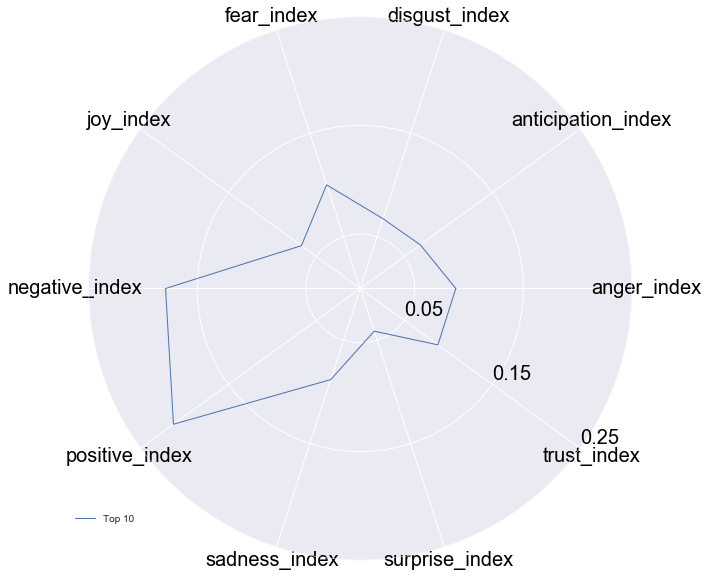

In [81]:

# number of variable
categories=lyrics
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=20)

# Draw ylabels
ax.set_rlabel_position(324)
plt.yticks([0.05,0.15,0.25], ["0.05","0.15","0.25"], color="black", size=20)
plt.ylim(0,0.25)
 
# Plot data
#ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
#ax.fill(angles, values, 'b', alpha=0.1)

values=df10_split2.mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Top 10")
#ax.fill(angles, values, 'b', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1,0.1))

In [86]:
df_top10_sorted = Final.sort_values(by='weeks_in_top', axis=0)
df_top10_sorted

,Position,Track Name,Artist,Streams,date,URI,release_date,length,danceability,acousticness,...,anger_index,anticipation_index,disgust_index,fear_index,joy_index,negative_index,positive_index,sadness_index,surprise_index,trust_index
71,7,Ghetto Fabulous,Tessa,413588,2020-08-07,spotify:track:4Al06vYvUi8uPCYzw2b80X,2020-08-07,143476,0.798,0.17800,...,0.133705,0.036212,0.142061,0.136490,0.019499,0.250696,0.103064,0.136490,0.016713,0.025070
38,9,WHIP WHOP,I$WAAL,293021,2020-04-17,spotify:track:1PxGMn63iT7sc4eS52c9UP,2020-04-17,211840,0.748,0.03430,...,0.205567,0.051392,0.062099,0.072805,0.057816,0.246253,0.122056,0.074946,0.047109,0.059957
42,6,SKRIV TIL MIG (feat. ICEKIID),TopGunn,362719,2020-04-24,spotify:track:2c4lM4r3EAwZIHzaNqJPRm,2020-04-24,168094,0.701,0.25200,...,0.081395,0.075581,0.058140,0.052326,0.110465,0.232558,0.220930,0.040698,0.063953,0.063953
27,10,Pas Oublié (feat. Gilli),Isaac Kasule,330760,2020-02-28,spotify:track:6kyJjIpIjaoBaNx0VjxcwL,2020-02-28,179714,0.745,0.01390,...,0.157407,0.074074,0.111111,0.148148,0.018519,0.212963,0.064815,0.175926,0.009259,0.027778
43,8,MASH,TopGunn,336595,2020-04-24,spotify:track:7p3h4ZE3d44Yp1NtVUvAEa,2020-04-24,118888,0.829,0.03870,...,0.077982,0.091743,0.050459,0.073394,0.091743,0.146789,0.215596,0.110092,0.068807,0.073394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,7,The Box,Roddy Ricch,409407,2020-01-10,spotify:track:0nbXyq5TXYPCO7pr3N8S4I,2019-12-06,196652,0.896,0.10400,...,0.118959,0.048327,0.074349,0.078067,0.055762,0.182156,0.219331,0.063197,0.063197,0.096654
18,1,LA DANZA,Branco,799537,2020-02-07,spotify:track:5M9phYS7KgM3ZXKTSlgLv0,2020-02-05,185711,0.780,0.22800,...,0.061135,0.048035,0.030568,0.030568,0.205240,0.100437,0.235808,0.104803,0.043668,0.139738
37,8,ROCKSTAR (feat. Roddy Ricch),DaBaby,303345,2020-04-17,spotify:track:7ytR5pFWmSjzHJIeQkgog4,2020-04-17,181733,0.746,0.24700,...,0.061372,0.057762,0.072202,0.108303,0.079422,0.151625,0.256318,0.057762,0.032491,0.122744
29,1,Blinding Lights,The Weeknd,613889,2020-03-20,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,2020-03-20,200040,0.514,0.00146,...,0.123596,0.044944,0.033708,0.112360,0.044944,0.280899,0.224719,0.067416,0.011236,0.056180


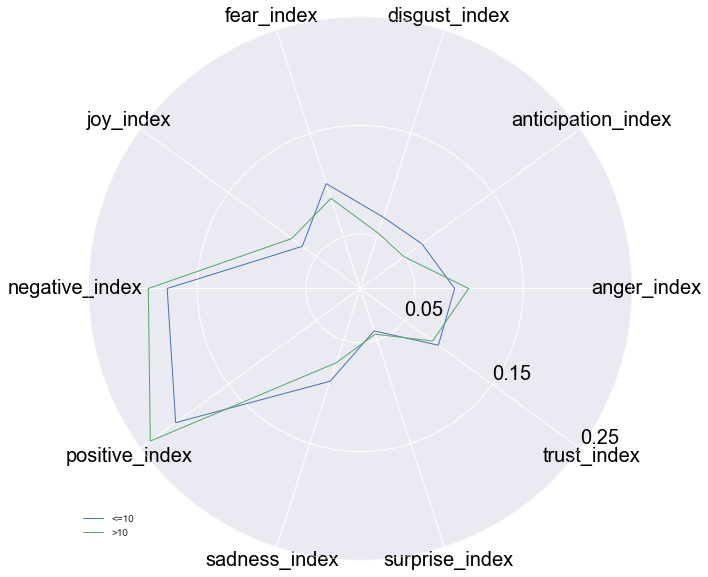

In [92]:
# number of variable
categories=lyrics
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=20)

# Draw ylabels
ax.set_rlabel_position(324)
plt.yticks([0.05,0.15,0.25], ["0.05","0.15","0.25"], color="black", size=20)
plt.ylim(0,0.25)
 
# Plot data
#ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
#ax.fill(angles, values, 'b', alpha=0.1)

values=df_top10_sorted[['anger_index', 'anticipation_index', 'disgust_index', 'fear_index', 'joy_index', 'negative_index', 'positive_index', 'sadness_index', 'surprise_index', 'trust_index']].loc[df_top10_sorted['weeks_in_top']<=10].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="<=10")
#ax.fill(angles, values, 'b', alpha=0.1)

values=df_top10_sorted[['anger_index', 'anticipation_index', 'disgust_index', 'fear_index', 'joy_index', 'negative_index', 'positive_index', 'sadness_index', 'surprise_index', 'trust_index']].loc[df_top10_sorted['weeks_in_top']>10].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=">10")
#ax.fill(angles, values, 'b', alpha=0.1)


plt.legend(loc='upper right', bbox_to_anchor=(0.1,0.1))